# GKP states

Ilan Tzitrin and J. Eli Bourassa

In this tutorial, we numerically simulate the preparation of an approximate Gottesman-Kitaev-Preskill (GKP) state using an optical circuit. The state we target is

$\left|0_\Delta\right> \approx S(0.196)[0.661\left|0\right> - 0.343\left|2\right> + 0.253\left|4\right>  - 0.368\left|6\right> + 0.377\left|8\right>  + 0.323\left|10\right>  + 0.365\left|12\right>]$,

which has 96.9% fidelity to the normalizable GKP state $\left|0_\Delta\right>$ for $\Delta = 10 \text{ dB}$. 

For more on GKP states, including the notation and terminology, see "Towards practical qubit computation using approximate error-correcting grid states" (arXiv:1910.03673) by I. Tzitrin, J. E. Bourassa, N. C. Menicucci, and K. K Sabapathy.

In [129]:
import numpy as np
from qutip import wigner, Qobj, wigner_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

## Ideal Preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the amount of squeezing and displacement to use. The origin of these parameters is discussed in the reference above.

In [190]:
m1, m2 = 5, 7
params = np.array([-1.38155106, -1.21699567,  0.7798817,  1.04182349,  
                   0.87702211, 0.90243916,  1.48353639,  1.6962906 , 
                   -0.24251599, 0.1958])
sq_r = params[:3]
bs_theta1, bs_theta2, bs_theta3 = params[3:6]
bs_phi1, bs_phi2, bs_phi3 = params[6:9]
sq_virt = params[9]

Now we setup a 3-mode quantum circuit in Strawberry Fields and obtain the covariance matrix and vector of means of the Gaussian state.

In [204]:
nmodes = 3
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")

with prog.context as q:
    for k in range(3):
        Sgate(sq_r[k]) | q[k]

    BSgate(bs_theta1, bs_phi1) | (q[0], q[1])
    BSgate(bs_theta2, bs_phi2) | (q[1], q[2])
    BSgate(bs_theta3, bs_phi3) | (q[0], q[1])
    
    Sgate(sq_virt) | q[2]

state = eng.run(prog).state
mu, cov = state.means(), state.cov()

In [185]:
# Here we use the sf circuit drawer and standard linux utilities
# to generate an svg representing the circuit
file, _ = prog.draw_circuit()
filepdf = file[0:-3]+"pdf"
filepdf = filepdf.replace("circuit_tex/","")
filecrop = filepdf.replace(".pdf","-crop.pdf")
name = "cubic_circuit.svg"
# !pdflatex  $file > /dev/null 2>&1
# !pdfcrop $filepdf > /dev/null 2>&1
# !pdf2svg $filecrop $name

We can now inspect the covariance matrix and vector of means. Note that the vector of means is zero since we did not use displacement gates in the circuit above. This is due to the symmetry of the GKP wavefunction about the origin in phase space.

In [205]:
print(np.round(mu, 10))
print(np.round(cov, 10))

[0. 0. 0. 0. 0. 0.]
[[ 5.00170445  0.15101176 -3.12729025 -3.93663741 -0.57864296  0.45079939]
 [ 0.15101176  4.88633214 -3.69458049 -1.32442707  3.78723601 -0.30858687]
 [-3.12729025 -3.69458049  4.798272    3.42705308 -2.38393578  0.05410287]
 [-3.93663741 -1.32442707  3.42705308  5.56202806  1.90025335  2.97323959]
 [-0.57864296  3.78723601 -2.38393578  1.90025335  6.15012337  3.65219485]
 [ 0.45079939 -0.30858687  0.05410287  2.97323959  3.65219485  5.4342486 ]]


We now use The Walrus to obtain the Fock representation of the Gaussian state emerging in the 3rd mode when modes 1 and 2 are heralded in the values $n_1=5$ and $n_2=7$. We also calculate the probability of success in heralding the state.

In [206]:
cutoff = 25
psi = state_vector(mu, cov, post_select={0: m1, 1: m2}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi / p_psi
print('The probability of successful heralding is {:.5f}.'.format(p_psi ** 2))

The probability of successful heralding is 0.00106.


We now plot the photon-number distribution of the heralded state. Note that the state has zero support on the odd Fock states due to its symmetry, and the support tapers off after $n=8$.

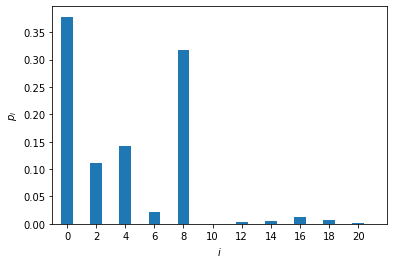

In [207]:
plt.bar(np.arange(cutoff), np.abs(psi) ** 2)
plt.xlim(-1, 22)
plt.xticks(np.arange(0, 22, 2))
plt.xlabel('$i$')
plt.ylabel(r'$p_i$')
plt.show()

We can now plot the Wigner function of the heralded state:

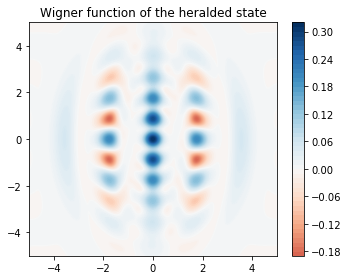

In [208]:
grid = 300
xvec = np.linspace(-5,5, grid)
Wp = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

and a cut of the Wigner function along $p=0$.

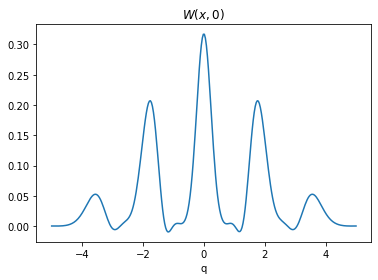

In [209]:
plt.plot(xvec, Wp[grid//2,:])
plt.title(r"$W(x,0)$")
plt.xlabel(r"q")
plt.show()